In [1]:
import datetime

from time import sleep
from math import sin, cos
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from xpcclient.simutils import *
from xpcclient.normalization import DF_Nomalize, denorm, _norm

INTERVAL = 0.05

2023-05-10 07:18:11.986787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df_list = []
lon_dfs = []
ail_dfs = []

records_dir = os.path.join('xpcclient', 'Records')
trimmed_lon_dir = os.path.join('xpcclient', 'Trimmed.lon')
trimmed_ail_dir = os.path.join('xpcclient', 'Trimmed.ail')

if not os.path.exists('figs'):
    os.mkdir('figs')

file_list = os.listdir(records_dir)
_file_list = []
for filename in file_list:
    if not filename.endswith('.csv') or not os.path.isfile(os.path.join(records_dir, filename)):
        continue

    _file_list.append(filename)
file_list = _file_list

max_30_index = 0
for filename in file_list:
    df = pd.read_csv(
        os.path.join(records_dir, filename)
    )
    lon_df = pd.read_csv(
        os.path.join(trimmed_lon_dir, filename)
    )

    df_list.append(df)
    lon_dfs.append(lon_df)

    n_index = df.loc[df['hralt'] < 30].index[0]
    if n_index > max_30_index:
        max_30_index = n_index



ail_list = os.listdir(trimmed_ail_dir)
for filename in ail_list:
    ail_dfs.append(
        pd.read_csv(
            os.path.join(trimmed_ail_dir, filename)
        )
    )

max_30_index


3649

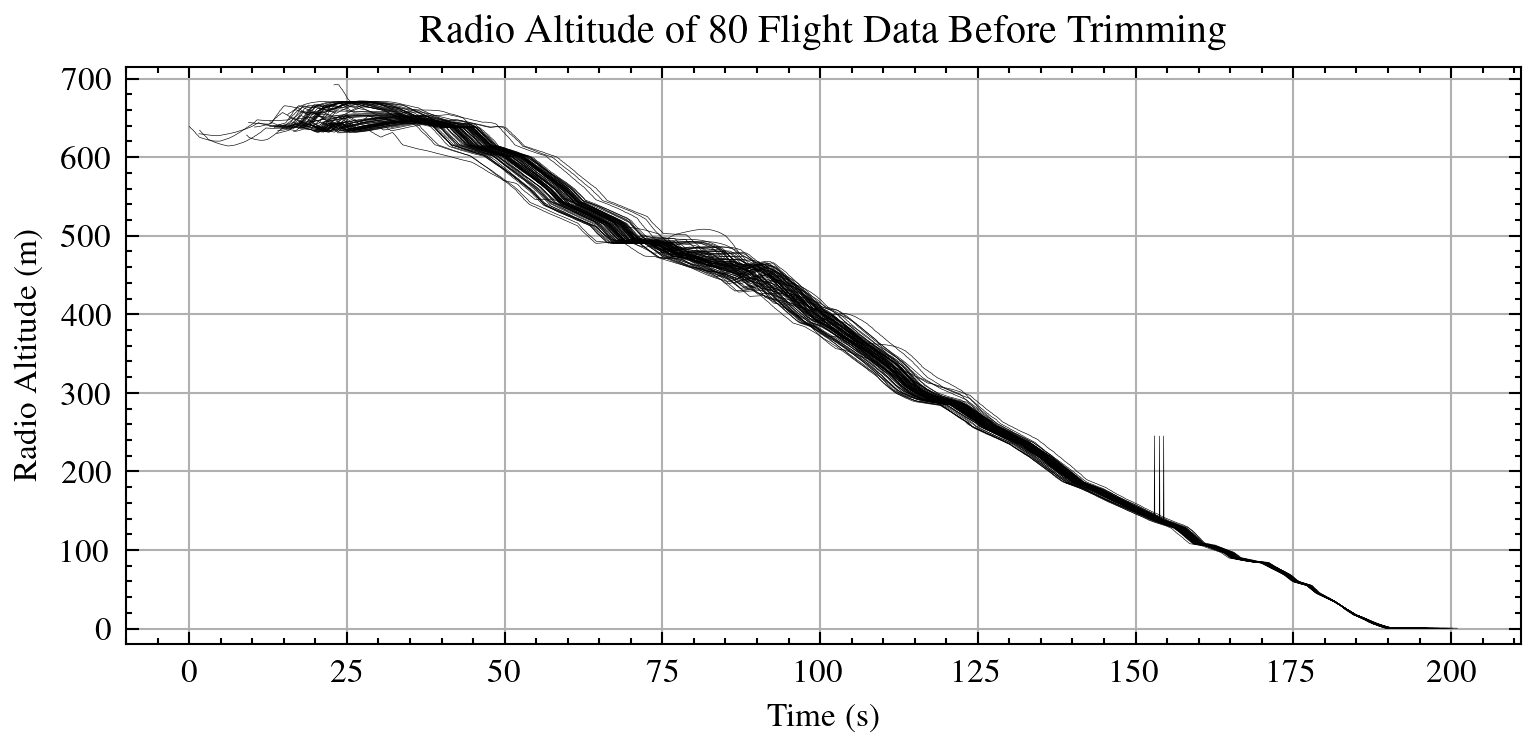

In [7]:
plt.style.use(['science', 'ieee'])

cut_0 = 33.50687500000015
cut_end = 182.45000000000294

fig = plt.figure(figsize=(6, 2.5), dpi=300)

for df in df_list:
    n_index = df.loc[df['hralt'] < 30].index[0]
    delta_ind = max_30_index - n_index

    plt.plot(df['time_s']+delta_ind*INTERVAL, df['hralt'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    

plt.xlabel('Time (s)')
plt.ylabel('Radio Altitude (m)')
plt.ylim((-20, 715))
plt.title('Radio Altitude of 80 Flight Data Before Trimming')
plt.grid()
plt.show()
fig.savefig('figs/ch3_hralt_before_cutting.png')
fig.savefig('figs/ch3_hralt_before_cutting.pdf')

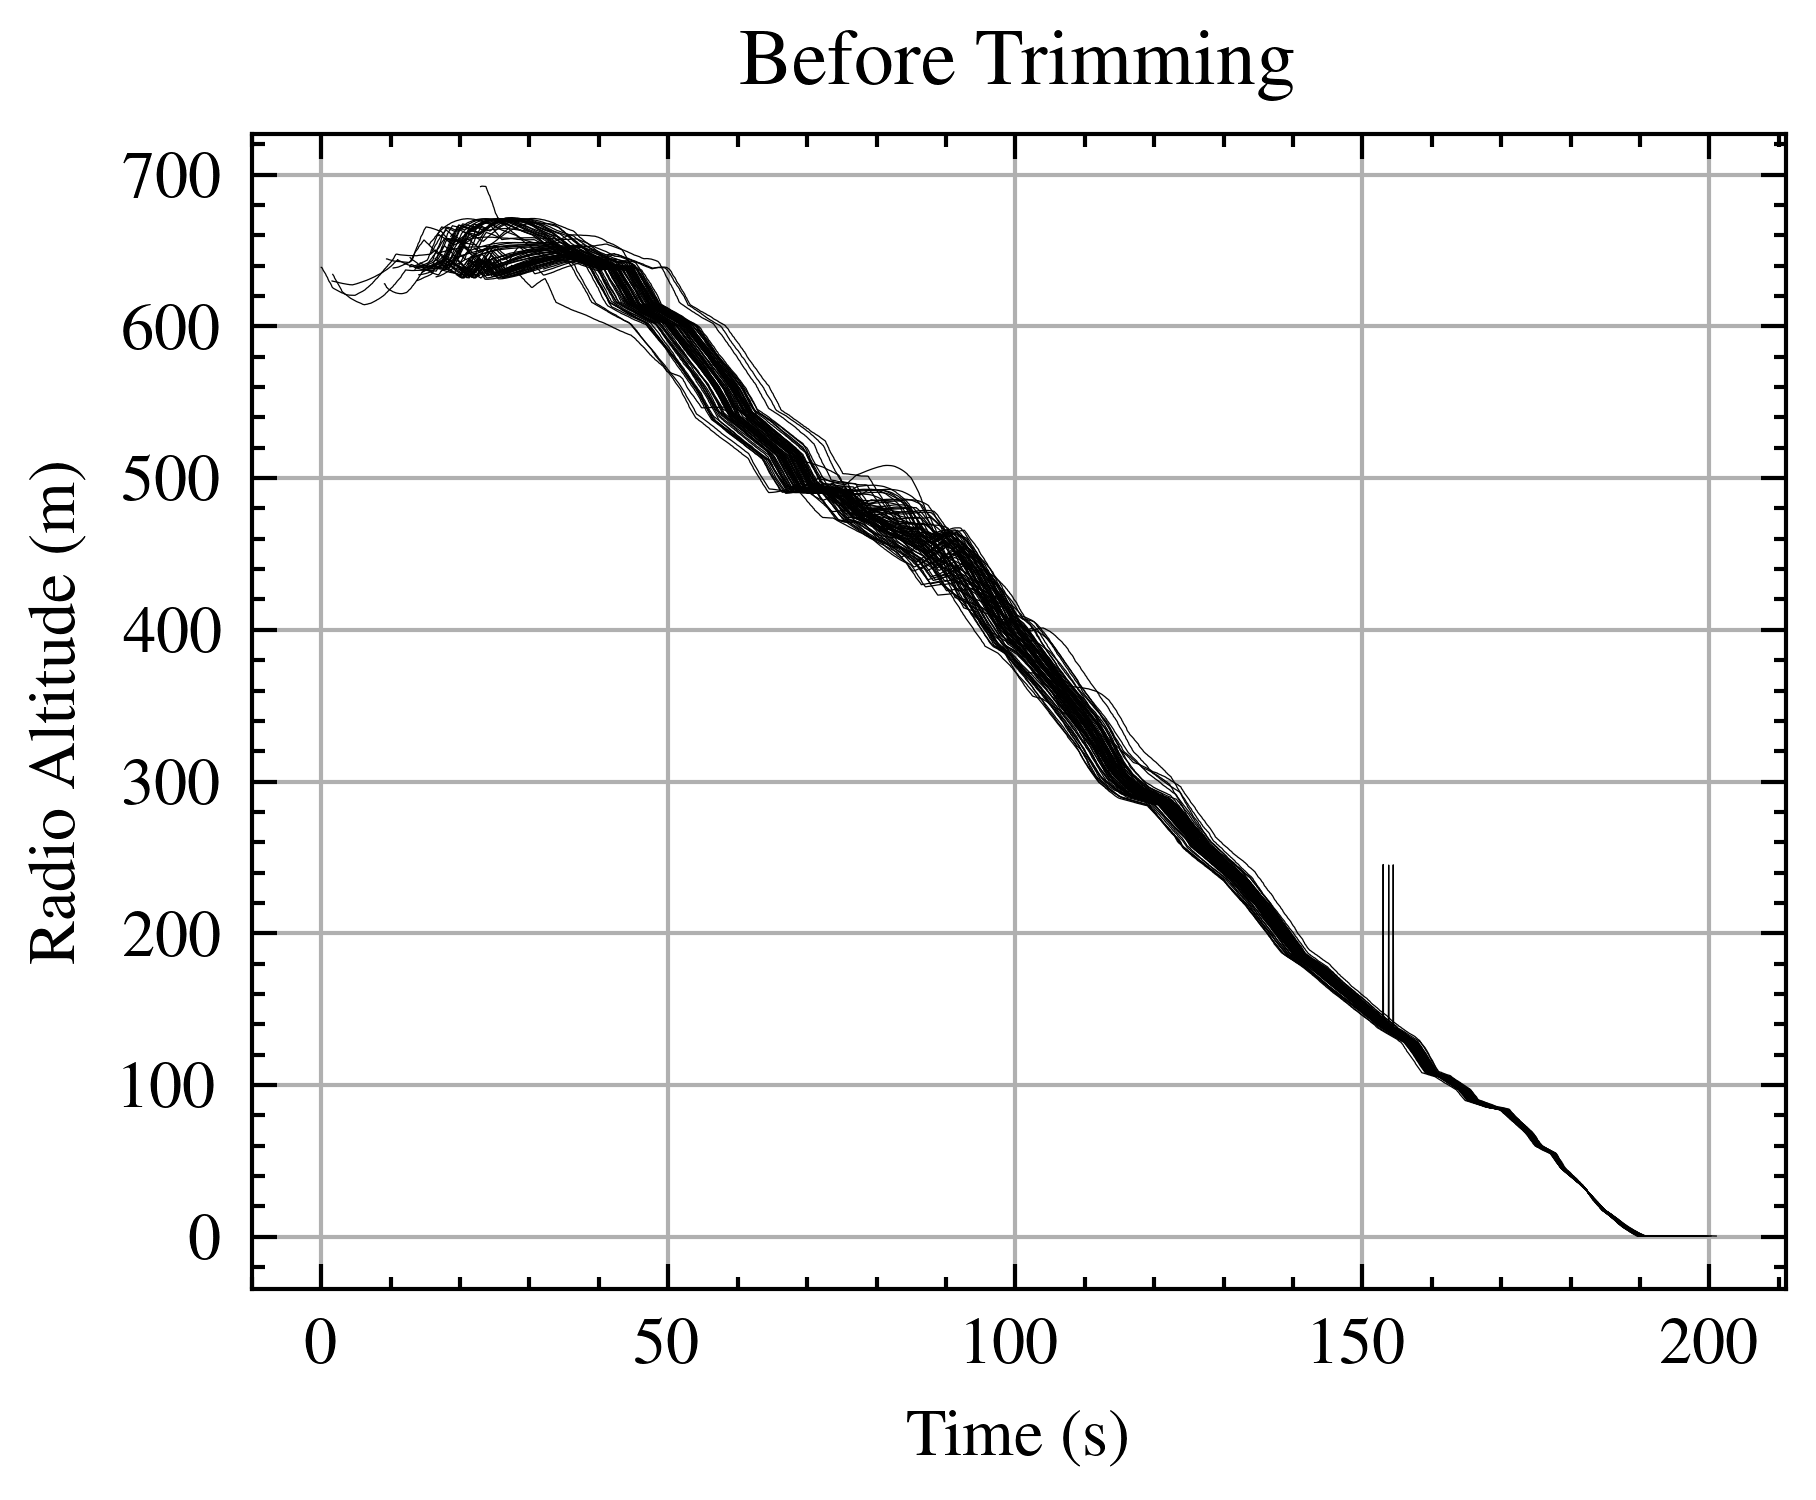

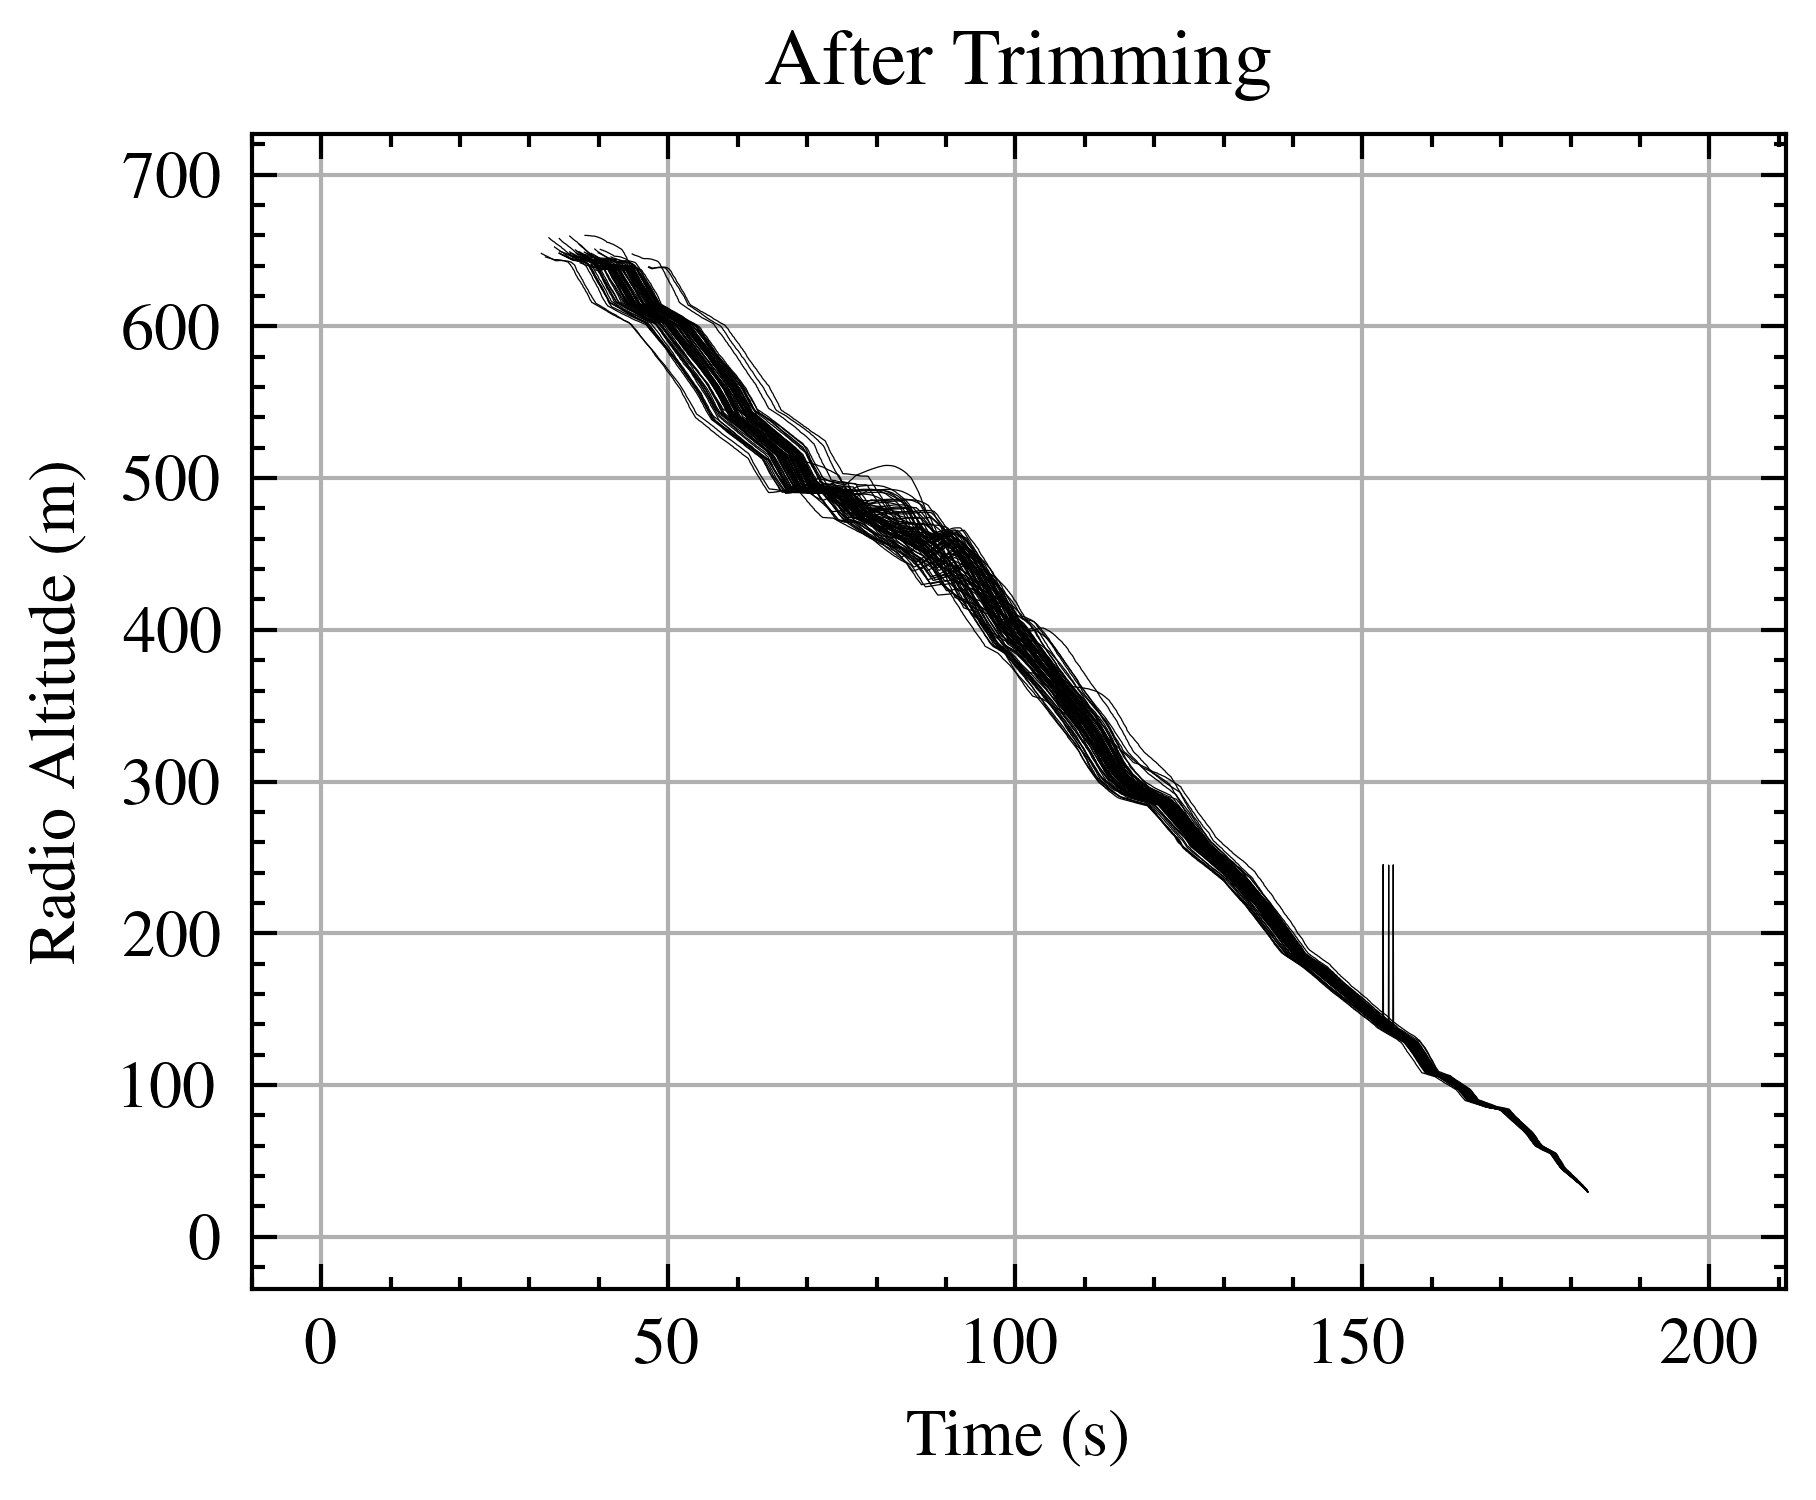

In [8]:
fig1 = plt.figure()
n_indexes = []

for df in df_list:
    n_index = df.loc[df['hralt'] < 30].index[0]
    n_indexes.append(n_index)
    delta_ind = max_30_index - n_index

    plt.plot(df['time_s']+delta_ind*INTERVAL, df['hralt'], alpha=1, color='k', linestyle='-', linewidth=0.15)

ylim = plt.ylim()
xlim = plt.xlim()
plt.xlabel('Time (s)')
plt.ylabel('Radio Altitude (m)')
plt.title('Before Trimming')
plt.grid()
plt.show()
fig1.savefig('figs/ch3_hralt_before_cut.pdf')


fig2 = plt.figure()

for i, df in enumerate(lon_dfs):
    n_index = n_indexes[i]
    delta_ind = max_30_index - n_index

    plt.plot(df['time_s']+delta_ind*INTERVAL, df['hralt'], alpha=1, color='k', linestyle='-', linewidth=0.15)

plt.xlabel('Time (s)')
plt.ylabel('Radio Altitude (m)')
plt.title('After Trimming')
plt.ylim(ylim)
plt.xlim(xlim)
plt.grid()
plt.show()
fig2.savefig('figs/ch3_hralt_after_cut.pdf')


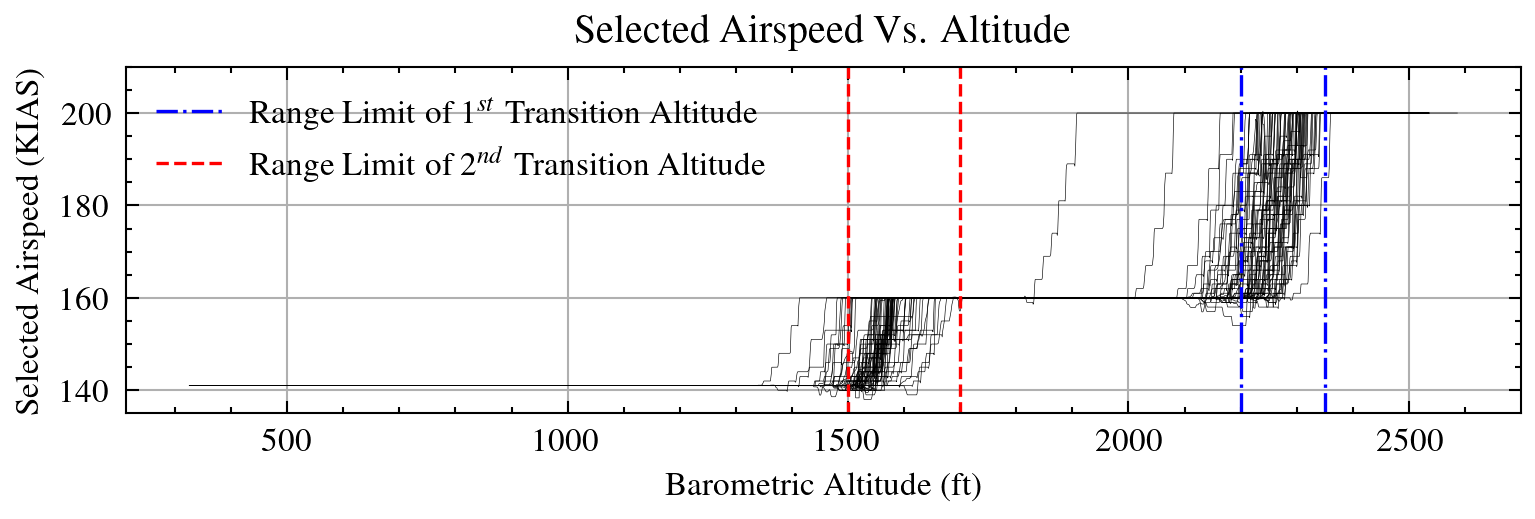

Bellow 200 t: 2274.588907994965
Bellow 160 t: 1572.6775712678686


In [10]:
plt.style.use(['science', 'ieee'])

fig = plt.figure(figsize=(6, 1.5), dpi=300)

t_b200 = 0
t_b160 = 0

for df in df_list:
    n_index = df.loc[df['hralt'] < 30].index[0]
    b_200_index = df.loc[df['sas'] < 200].index[0]
    b_160_index = df.loc[(df['sas'] < 159) * (df['hbaro']*3.28084 < 1750)].index[0]

    t_b200 += df.loc[b_200_index, 'hbaro']*3.28084
    t_b160 += df.loc[b_160_index, 'hbaro']*3.28084

    delta_ind = max_30_index - n_index

    plt.plot(df['hbaro']*3.28084, df['sas'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    
cut_00, cut_01 = 2350, 2200
cut_10, cut_11 = 1700, 1500

plt.plot((cut_00, cut_00), (-100, 900), color='b', linestyle='dashdot', linewidth=.8, label=r'Range Limit of $1^{st}$ Transition Altitude')
plt.plot((cut_01, cut_01), (-100, 900), color='b', linestyle='dashdot', linewidth=.8)
plt.plot((cut_10, cut_10), (-100, 900), color='r', linestyle='dashed', linewidth=.8, label=r'Range Limit of $2^{nd}$ Transition Altitude')
plt.plot((cut_11, cut_11), (-100, 900), color='r', linestyle='dashed', linewidth=.8)

plt.legend()
plt.xlabel('Barometric Altitude (ft)')
plt.ylabel('Selected Airspeed (KIAS)')
plt.title('Selected Airspeed Vs. Altitude')
plt.ylim((135, 210))
plt.grid()
plt.show()
fig.savefig('figs/ch3_sas_v_baro.pdf')

print ("Bellow 200 t: {}".format(t_b200/len(df_list)))
print ("Bellow 160 t: {}".format(t_b160/len(df_list)))

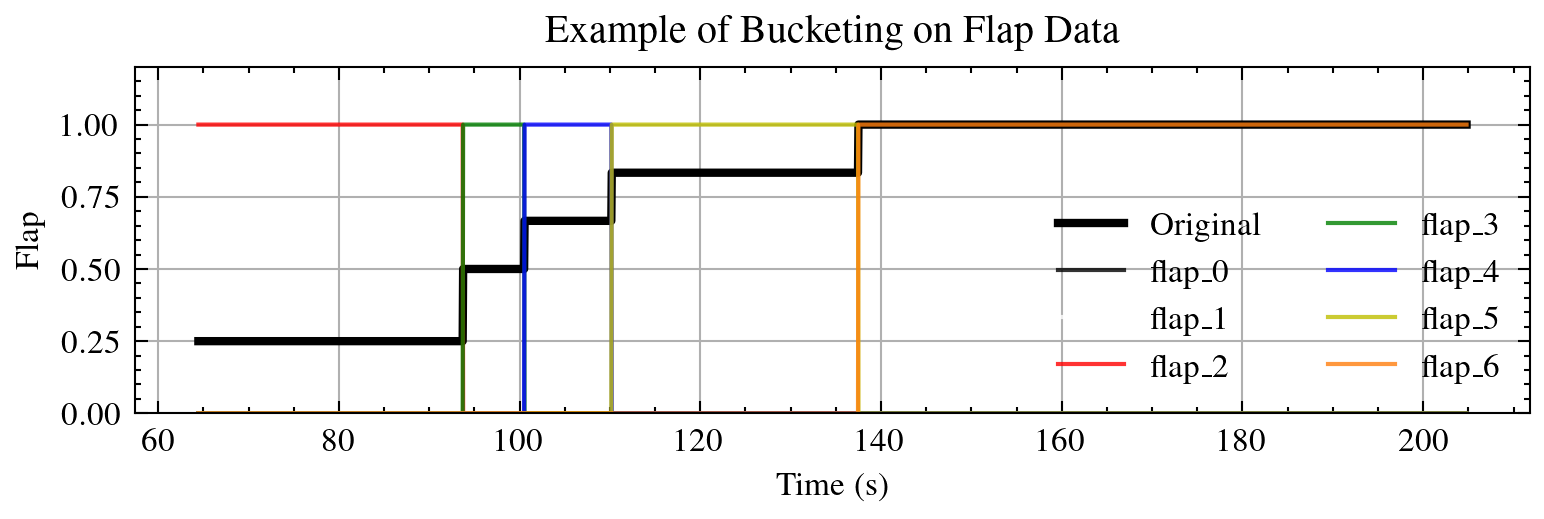

In [11]:
plt.style.use(['science', 'ieee'])

fig = plt.figure(figsize=(6, 1.5), dpi=300)

df = lon_dfs[4]

n_index = df.loc[df['hralt'] < 30].index[0]
delta_ind = max_30_index - n_index

plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_rat'], color = 'k', linewidth=2)

plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_0_bool'], alpha = 0.8, linestyle='-', color='k', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_1_bool'], alpha = 0.8, linestyle='-', color='white', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_2_bool'], alpha = 0.8, linestyle='-', color='r', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_3_bool'], alpha = 0.8, linestyle='-', color='g', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_4_bool'], alpha = 0.8, linestyle='-', color='b', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_5_bool'], alpha = 0.8, linestyle='-', color='y', linewidth=1)
plt.plot(df['time_s']+delta_ind*INTERVAL, df['flap_6_bool'], alpha = 0.8, linestyle='-', color='tab:orange', linewidth=1)
    
plt.xlabel('Time (s)')
plt.ylabel('Flap')
plt.title('Example of Bucketing on Flap Data')
plt.legend(['Original', 'flap_0', 'flap_1', 'flap_2', 'flap_3', 'flap_4', 'flap_5', 'flap_6'], loc=4, ncol=2)
plt.ylim((0, 1.2))
plt.grid()
plt.show()
fig.savefig('figs/ch3_flap_bucketing.pdf')

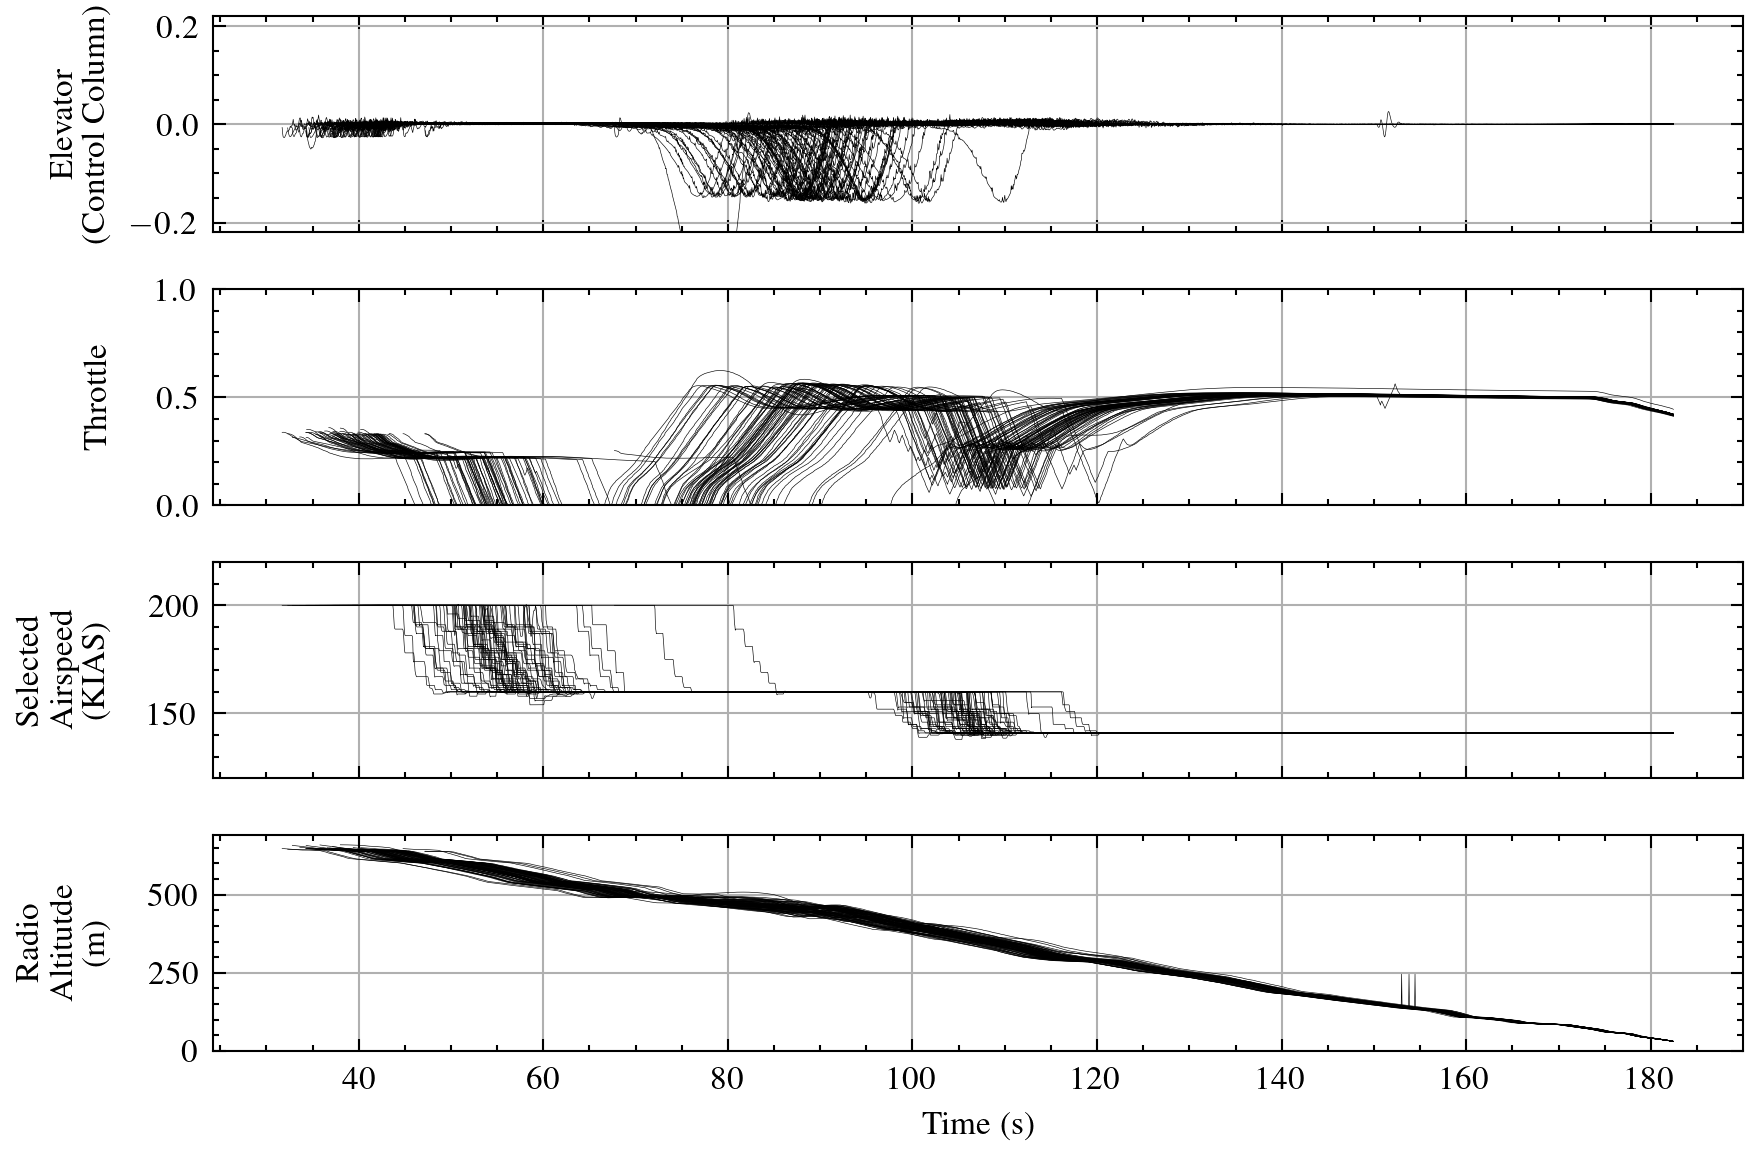

In [12]:
plt.style.use(['science', 'ieee'])

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(6, 1*4)
fig.set_dpi(300)

for i, df in enumerate(lon_dfs):
    n_index = n_indexes[i]
    delta_ind = max_30_index - n_index

    axs[0].plot(df['time_s']+delta_ind*INTERVAL, df['ctrl_col'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[1].plot(df['time_s']+delta_ind*INTERVAL, df['throttle'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[2].plot(df['time_s']+delta_ind*INTERVAL, df['sas'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[3].plot(df['time_s']+delta_ind*INTERVAL, df['hralt'], alpha=1, color='k', linestyle='-', linewidth=0.15)

axs[3].set_xlabel('Time (s)')

axs[0].set_ylabel('Elevator\n(Control Column)')
axs[1].set_ylabel('Throttle')
axs[2].set_ylabel('Selected\nAirspeed\n(KIAS)')
axs[3].set_ylabel('Radio\nAltitutde\n(m)')

axs[0].set_ylim((-0.22, 0.22))
axs[1].set_ylim((0, 1))
axs[2].set_ylim((120, 220))

axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[2].set_xticklabels([])

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

fig.align_ylabels(axs[:])

plt.tight_layout()
plt.show()
fig.savefig('figs/ch4_training_data_lon_1.pdf')

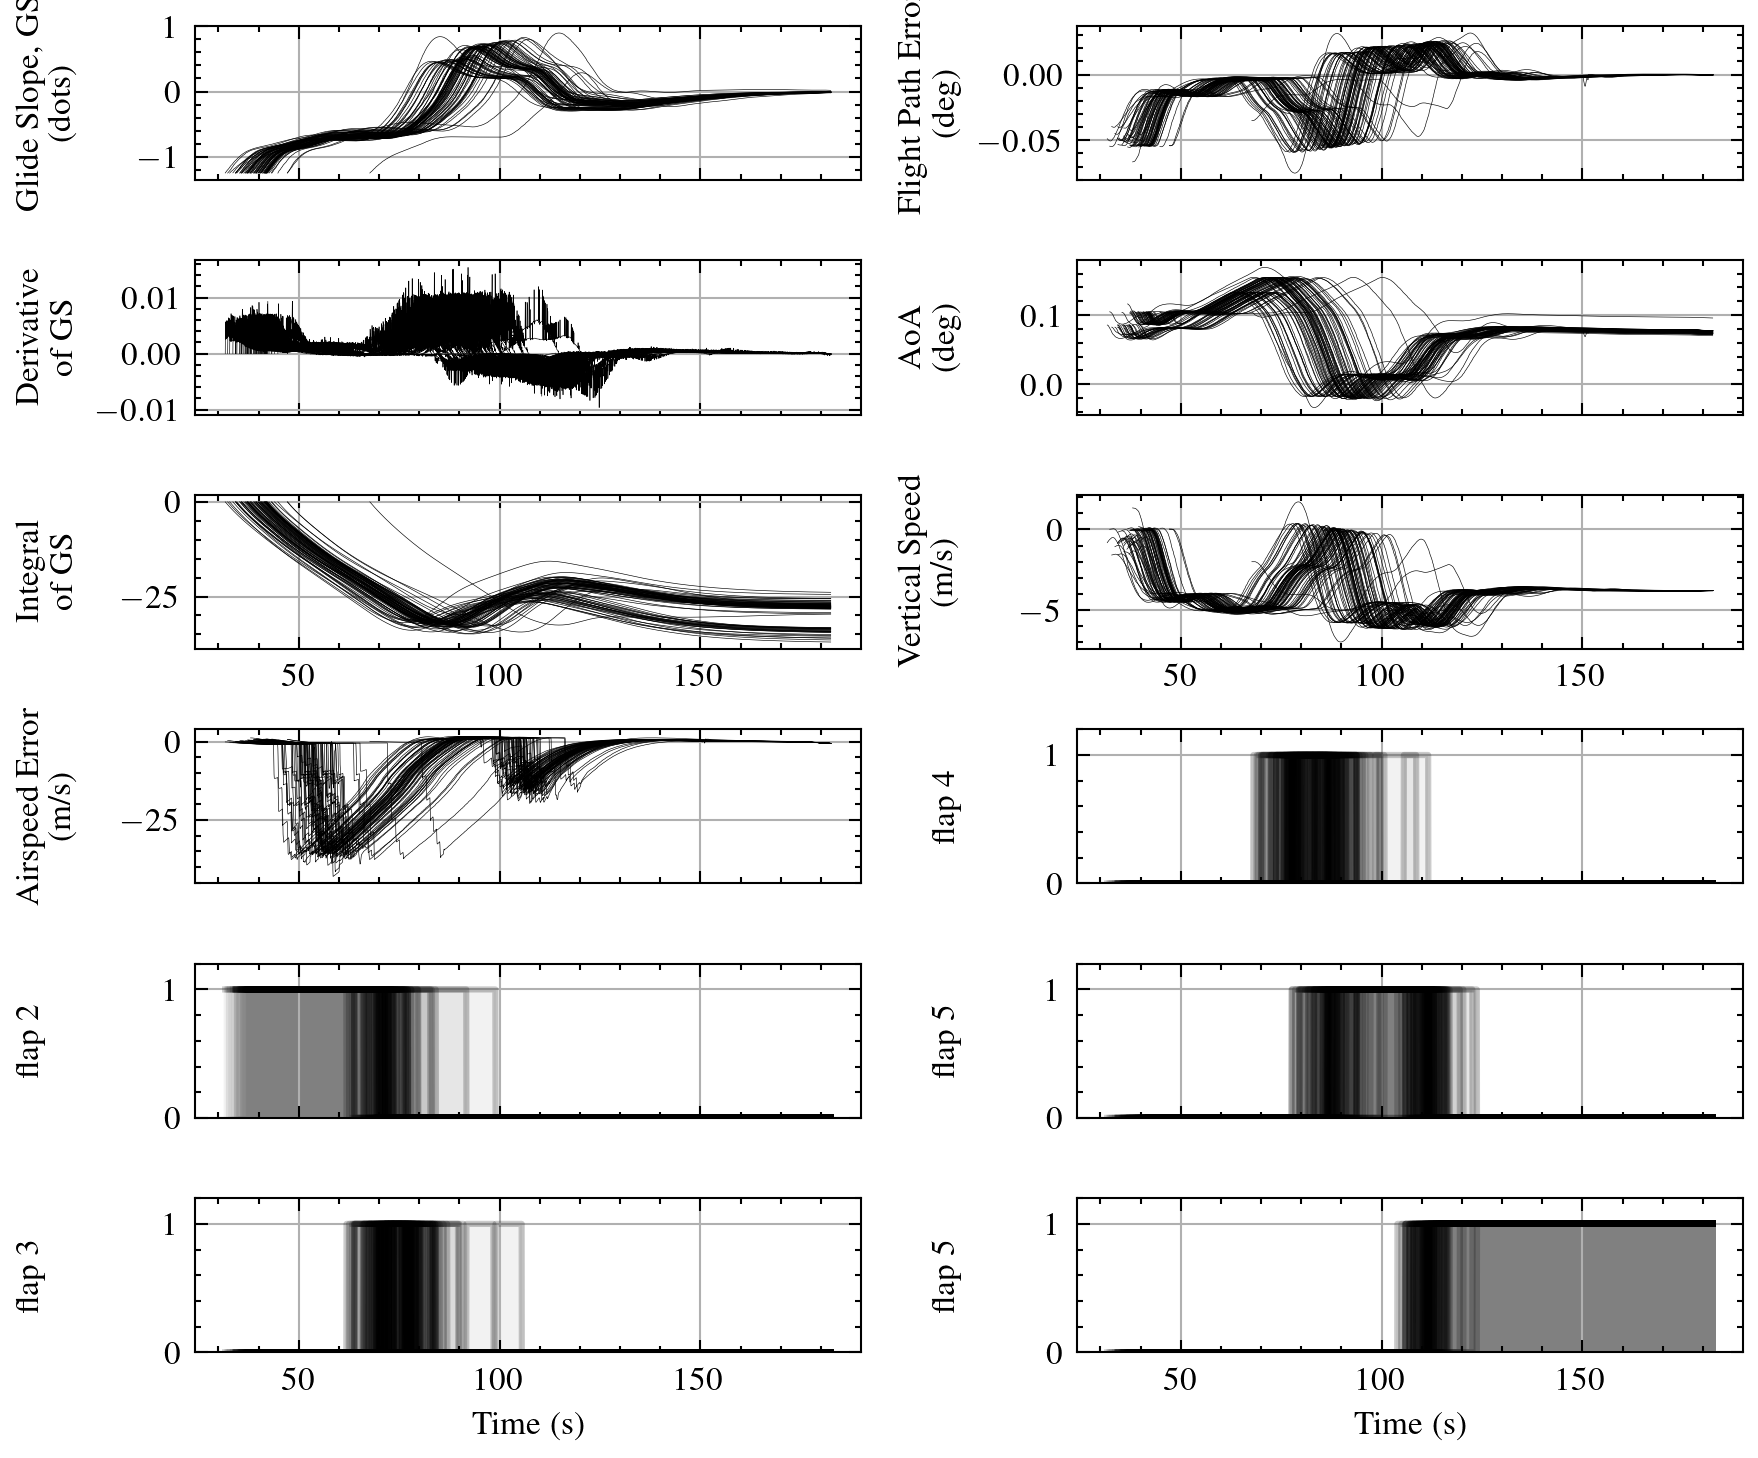

In [13]:
plt.style.use(['science', 'ieee'])

fig, axs = plt.subplots(6, 2)
fig.set_size_inches(6, 2*2.5)
fig.set_dpi(300)

for i, df in enumerate(lon_dfs):
    n_index = n_indexes[i]
    delta_ind = max_30_index - n_index

    axs[0, 0].plot(df['time_s']+delta_ind*INTERVAL, df['gs'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[1, 0].plot(df['time_s']+delta_ind*INTERVAL, df['gs_d'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[2, 0].plot(df['time_s']+delta_ind*INTERVAL, df['gs_i'], alpha=1, color='k', linestyle='-', linewidth=0.15)

    axs[0, 1].plot(df['time_s']+delta_ind*INTERVAL, df['gamma_err'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[1, 1].plot(df['time_s']+delta_ind*INTERVAL, df['alpha'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[2, 1].plot(df['time_s']+delta_ind*INTERVAL, df['hdot'], alpha=1, color='k', linestyle='-', linewidth=0.15)

    # 
    axs[3, 0].plot(df['time_s']+delta_ind*INTERVAL, df['ias_err'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[4, 0].plot(df['time_s']+delta_ind*INTERVAL, df['flap_2_bool'], alpha=0.2, color='k', linestyle='-', linewidth=1.5)
    axs[4, 0].fill_between(
        x = df['time_s']+delta_ind*INTERVAL, 
        y1= df['flap_2_bool'],  
        where = df['flap_2_bool'] > 0.1,
        color='gray', alpha=0.1,)
    axs[5, 0].plot(df['time_s']+delta_ind*INTERVAL, df['flap_3_bool'], alpha=0.2, color='k', linestyle='-', linewidth=1.5)
    axs[5, 0].fill_between(
        x = df['time_s']+delta_ind*INTERVAL, 
        y1= df['flap_3_bool'],  
        where = df['flap_3_bool'] > 0.1,
        color='gray', alpha=0.1,)

    axs[3, 1].plot(df['time_s']+delta_ind*INTERVAL, df['flap_4_bool'], alpha=0.2, color='k', linestyle='-', linewidth=1.5)
    axs[3, 1].fill_between(
        x = df['time_s']+delta_ind*INTERVAL, 
        y1= df['flap_4_bool'],  
        where = df['flap_4_bool'] > 0.1,
        color='gray', alpha=0.1,)
    axs[4, 1].plot(df['time_s']+delta_ind*INTERVAL, df['flap_5_bool'], alpha=0.2, color='k', linestyle='-', linewidth=1.5)
    axs[4, 1].fill_between(
        x = df['time_s']+delta_ind*INTERVAL, 
        y1= df['flap_5_bool'],  
        where = df['flap_5_bool'] > 0.1,
        color='gray', alpha=0.1,)
    axs[5, 1].plot(df['time_s']+delta_ind*INTERVAL, df['flap_6_bool'], alpha=0.2, color='k', linestyle='-', linewidth=1.5)
    axs[5, 1].fill_between(
        x = df['time_s']+delta_ind*INTERVAL, 
        y1= df['flap_6_bool'],  
        where = df['flap_6_bool'] > 0.1,
        color='gray', alpha=0.1,)

axs[5, 0].set_xlabel('Time (s)')
axs[5, 1].set_xlabel('Time (s)')

axs[0, 0].set_ylabel('Glide Slope, GS\n(dots)')
axs[1, 0].set_ylabel('Derivative\nof GS')
axs[2, 0].set_ylabel('Integral\nof GS')

axs[0, 1].set_ylabel('Flight Path Error\n(deg)')
axs[1, 1].set_ylabel('AoA\n(deg)')
axs[2, 1].set_ylabel('Vertical Speed\n(m/s)')


axs[3, 0].set_ylabel('Airspeed Error\n(m/s)')
axs[4, 0].set_ylabel('flap 2\n')
axs[5, 0].set_ylabel('flap 3\n')

axs[3, 1].set_ylabel('flap 4')
axs[4, 1].set_ylabel('flap 5')
axs[5, 1].set_ylabel('flap 5')

axs[4, 0].set_ylim((0, 1.2))
axs[5, 0].set_ylim((0, 1.2))

axs[3, 1].set_ylim((0, 1.2))
axs[4, 1].set_ylim((0, 1.2))
axs[5, 1].set_ylim((0, 1.2))

for i in range(6):
    for j in range(2):
        axs[i, j].grid()
        if i == 2 or i == 5:
            continue
        axs[i, j].set_xticklabels([])

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

plt.tight_layout()
plt.show()
fig.savefig('figs/ch4_training_data_lon_2.pdf')

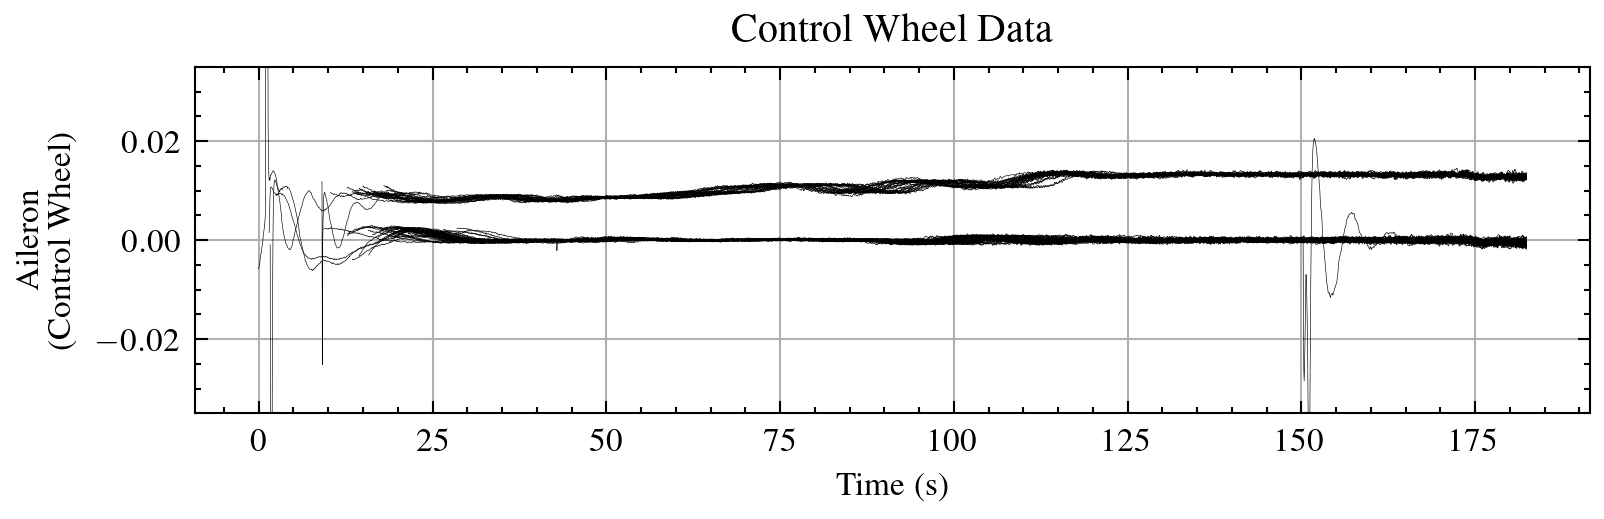

In [14]:
plt.style.use(['science', 'ieee'])

fig = plt.figure(figsize=(6, 1.5), dpi=300)

for df in ail_dfs:
    n_index = df.shape[0]
    delta_ind = max_30_index - n_index

    plt.plot(df['time_s']+delta_ind*INTERVAL, df['ctrl_whl'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    
plt.xlabel('Time (s)')
plt.ylabel('Aileron\n(Control Wheel)')
plt.title('Control Wheel Data')
plt.ylim((-0.035, 0.035))
plt.grid()
plt.show()
fig.savefig('figs/ch4_ctrl_whl.pdf')

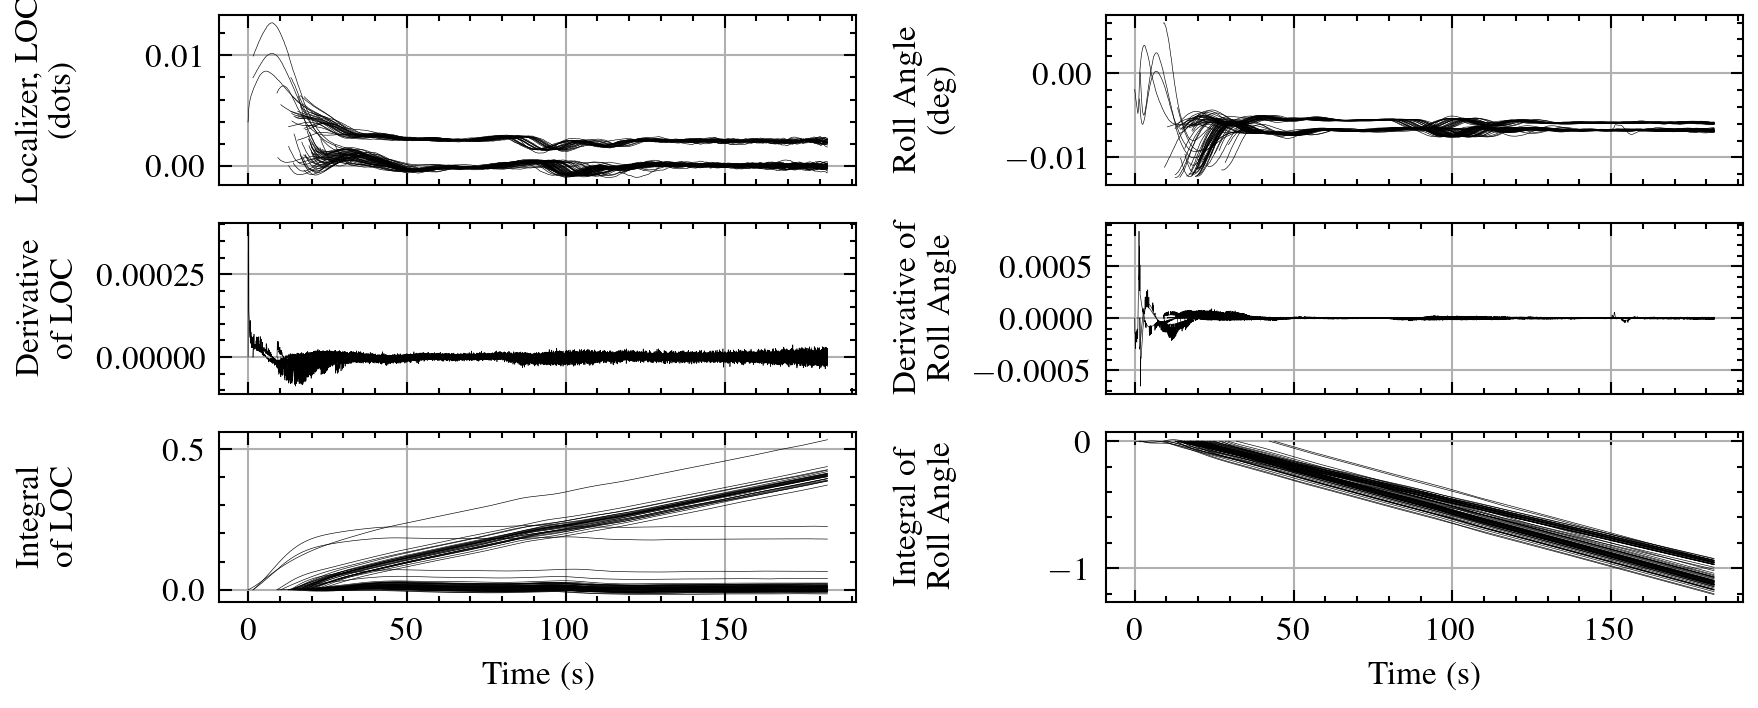

In [15]:
plt.style.use(['science', 'ieee'])

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(6, 2.5)
fig.set_dpi(300)

for i, df in enumerate(ail_dfs):
    n_index = df.shape[0]
    delta_ind = max_30_index - n_index

    axs[0, 0].plot(df['time_s']+delta_ind*INTERVAL, df['loc'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[1, 0].plot(df['time_s']+delta_ind*INTERVAL, df['loc_d'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[2, 0].plot(df['time_s']+delta_ind*INTERVAL, df['loc_i'], alpha=1, color='k', linestyle='-', linewidth=0.15)

    axs[0, 1].plot(df['time_s']+delta_ind*INTERVAL, df['phi'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[1, 1].plot(df['time_s']+delta_ind*INTERVAL, df['phi_d'], alpha=1, color='k', linestyle='-', linewidth=0.15)
    axs[2, 1].plot(df['time_s']+delta_ind*INTERVAL, df['phi_i'], alpha=1, color='k', linestyle='-', linewidth=0.15)

axs[2, 0].set_xlabel('Time (s)')
axs[2, 1].set_xlabel('Time (s)')

axs[0, 0].set_ylabel('Localizer, LOC\n(dots)')
axs[1, 0].set_ylabel('Derivative\nof LOC')
axs[2, 0].set_ylabel('Integral\nof LOC')

axs[0, 1].set_ylabel('Roll Angle\n(deg)')
axs[1, 1].set_ylabel('Derivative of\nRoll Angle')
axs[2, 1].set_ylabel('Integral of\nRoll Angle')

for i in range(3):
    for j in range(2):
        axs[i, j].grid()
        if i == 2 or i == 5:
            continue
        axs[i, j].set_xticklabels([])

fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])

plt.tight_layout()
plt.show()
fig.savefig('figs/ch4_training_data_lat.pdf')